** Model Training and Evaluation for Food Trend Prediction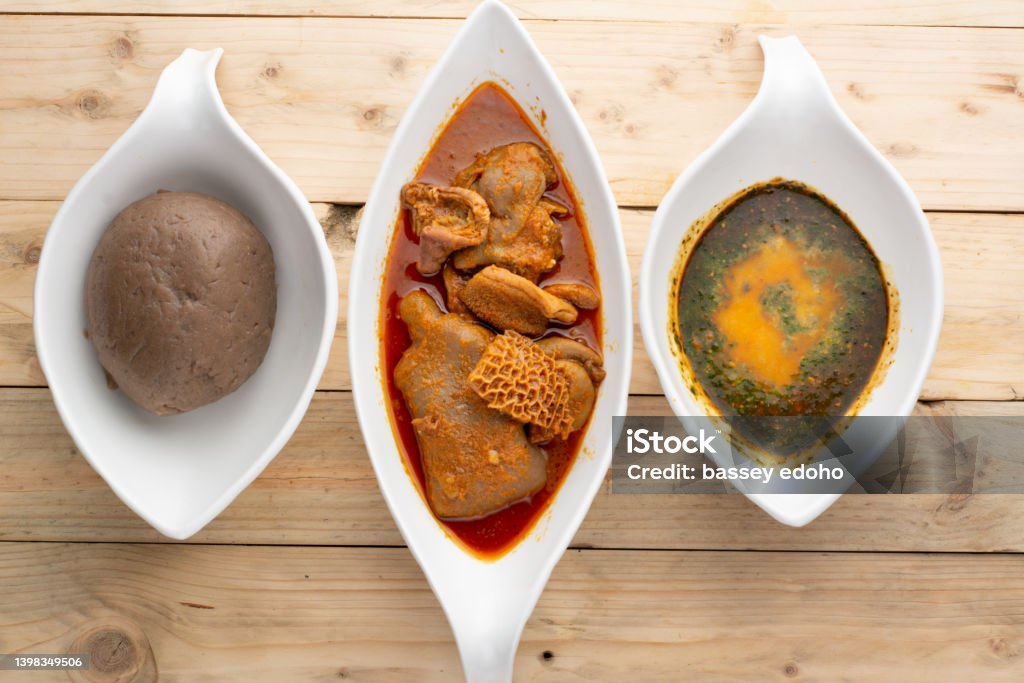**
This notebook will demonstrate how to build, tune, and evaluate a machine learning model to predict food trendiness based on historical Google Trends data

In [1]:
!pip install lightgbm
!pip install XGBoost
!pip install imbalanced-learn

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline # Essential for integrating SMOTE into CV
from scipy.stats import randint, uniform

import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load trend data
df_1 = pd.read_csv('/content/drive/MyDrive/research/Amala-trend-detection-uk-Rubic1-branch/data/amala_trends_20250617.csv')
df_2 = pd.read_csv('/content/drive/MyDrive/research/Amala-trend-detection-uk-Rubic1-branch/data/pounded_yam_trends_20250618.csv')
df_3 = pd.read_csv('/content/drive/MyDrive/research/Amala-trend-detection-uk-Rubic1-branch/data/jollof_rice_trends_20250618.csv')




In [4]:
df = pd.merge(df_1, df_2, on='date', how='outer')
df = pd.merge(df, df_3, on='date', how='outer')

In [5]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         262 non-null    object
 1   Amala        262 non-null    int64 
 2   Pounded yam  262 non-null    int64 
 3   jollof rice  262 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 8.3+ KB


In [6]:
df.isna().sum()

,0
date,0
Amala,0
Pounded yam,0
jollof rice,0


No empty rows


 **Feature Engineering**

For trend prediction, features will primarily be derived from the Trend_Index itself (lags, rolling means) and time-based features.

**Target Variable Definition**:

 For simplicity, we  define "High Trend" based on a threshold of the Trend_Index. In a real scenario, this threshold would be determined by business domain knowledge.

In [7]:
# Melt the DataFrame to a long format for easier processing per dish
df_melted = pd.melt(df, id_vars=['date'], var_name='dish', value_name='trend_index')
df_long = df_melted.sort_values(by=['date', 'dish'])

In [8]:
def create_time_based_feature(df):
  df['month'] = pd.to_datetime(df['date']).dt.month
  df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
  df['day_of_month'] = pd.to_datetime(df['date']).dt.day
  df['quarter'] = pd.to_datetime(df['date']).dt.quarter
  return df

def create_trend_features(df):
  # Corrected column name from 'trend_Index' to 'trend_index'
  df['trend_lag_1'] = df['trend_index'].shift(1)
  df['trend_lag_7'] = df['trend_index'].shift(7)#weekly lag
  df['trend_lag_30'] = df['trend_index'].shift(30) #monthly lag
  # Corrected column name from 'Dish' to 'dish' and 'trend_Index' to 'trend_index'
  df['Trend_Index_RollMean7'] = df.groupby('dish')['trend_index'].rolling(window=7).mean().reset_index(level=0, drop=True)
  # Corrected column name from 'Dish' to 'dish' and 'trend_Index' to 'trend_index'
  df['Trend_Index_RollMean30'] = df.groupby('dish')['trend_index'].rolling(window=30).mean().reset_index(level=0, drop=True)

  return df

In [9]:
df_long = create_time_based_feature(df_long)
df_long = create_trend_features(df_long)

df_long = df_long.dropna()

treshold =70

df_long['is_high_trend'] = (df_long['trend_index'] >= treshold).astype(int) # Example threshold


In [10]:
df_long

,date,dish,trend_index,month,day_of_week,day_of_month,quarter,trend_lag_1,trend_lag_7,trend_lag_30,Trend_Index_RollMean7,Trend_Index_RollMean30,is_high_trend
29,2021-01-03,Amala,18,1,6,3,1,7.0,4.0,34.0,25.428571,28.800000,0
291,2021-01-03,Pounded yam,45,1,6,3,1,18.0,36.0,0.0,28.714286,25.600000,0
553,2021-01-03,jollof rice,7,1,6,3,1,45.0,0.0,8.0,6.285714,7.066667,0
30,2021-01-10,Amala,29,1,6,10,1,7.0,7.0,32.0,26.285714,28.700000,0
292,2021-01-10,Pounded yam,72,1,6,10,1,29.0,34.0,38.0,39.000000,27.166667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,2025-06-08,Pounded yam,54,6,6,8,2,51.0,62.0,61.0,51.285714,54.933333,0
784,2025-06-08,jollof rice,9,6,6,8,2,54.0,67.0,8.0,9.285714,9.433333,0
261,2025-06-15,Amala,55,6,6,15,2,9.0,11.0,63.0,55.428571,55.166667,0
523,2025-06-15,Pounded yam,53,6,6,15,2,55.0,51.0,62.0,48.714286,54.033333,0


In [11]:
df_long.is_high_trend.value_counts()

,count
is_high_trend,
0,664
1,35


# New Section

OUTLIER DETECTION

In [12]:
df_long['trend_index_zscore'] = df_long.groupby('dish')['trend_index'].transform(lambda x: np.abs((x - x.mean()) / x.std()))

# Define a Z-score threshold (e.g., 3 standard deviations)
zscore_threshold = 3

# Identify outliers
df_outliers_zscore = df_long[df_long['trend_index_zscore'] > zscore_threshold]

print(f"--- Outliers detected using Z-score (threshold > {zscore_threshold}) ---")
print(df_outliers_zscore[['date', 'dish', 'trend_index', 'trend_index_zscore']].head())
print(f"Total Z-score outliers found: {len(df_outliers_zscore)}")





--- Outliers detected using Z-score (threshold > 3) ---
           date         dish  trend_index  trend_index_zscore
325  2021-08-29  Pounded yam            0            3.115718
333  2021-10-24  Pounded yam            0            3.115718
334  2021-10-31  Pounded yam            0            3.115718
341  2021-12-19  Pounded yam            0            3.115718
372  2022-07-24  Pounded yam            0            3.115718
Total Z-score outliers found: 11


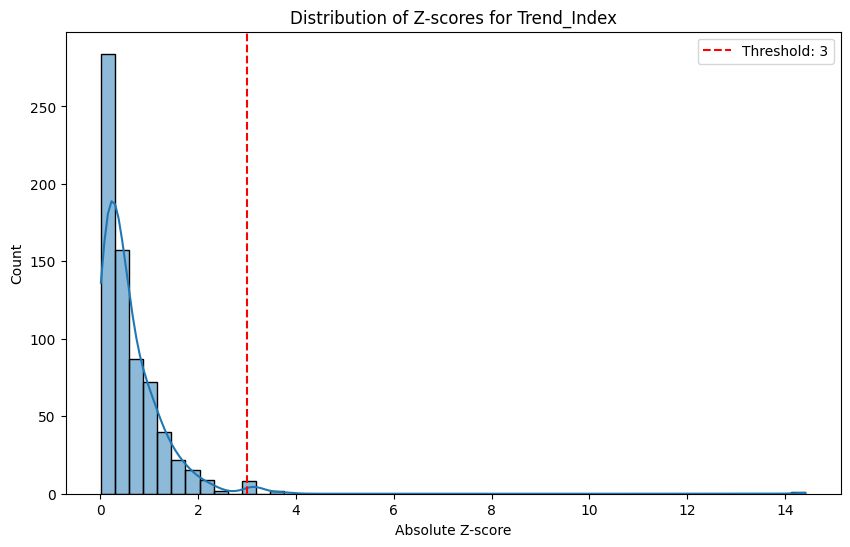

In [13]:
# Visualizing Z-score distribution (optional)
plt.figure(figsize=(10, 6))
sns.histplot(df_long['trend_index_zscore'], bins=50, kde=True)
plt.axvline(zscore_threshold, color='red', linestyle='--', label=f'Threshold: {zscore_threshold}')
plt.title('Distribution of Z-scores for Trend_Index')
plt.xlabel('Absolute Z-score')
plt.ylabel('Count')
plt.legend()
plt.show()

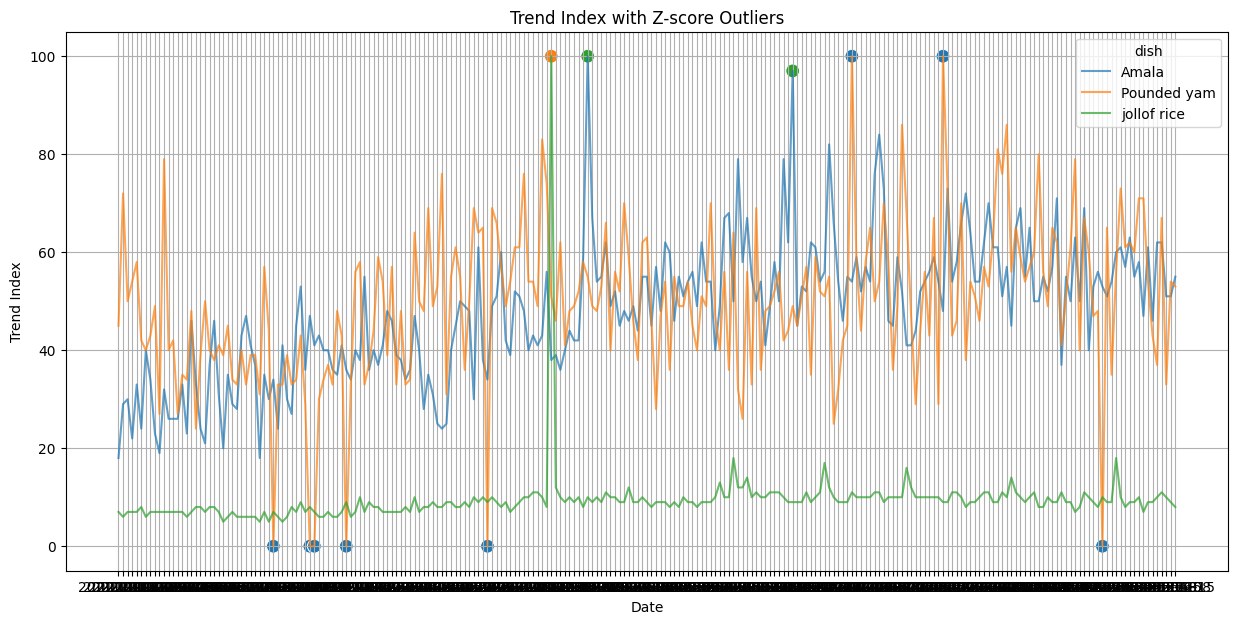

In [14]:
# You can also visualize the outliers on a time series plot
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_long, x='date', y='trend_index', hue='dish', alpha=0.7)
sns.scatterplot(data=df_outliers_zscore, x='date', y='trend_index', hue='dish',
                marker='o', s=100, color='red', legend=False, label='Z-score Outlier') # Mark outliers
plt.title('Trend Index with Z-score Outliers')
plt.xlabel('Date')
plt.ylabel('Trend Index')
plt.grid(True)
plt.show()

we detect few outliers , we can go ahead with our model training

In [15]:
# Print column names to verify
print(df_long.columns)

Index(['date', 'dish', 'trend_index', 'month', 'day_of_week', 'day_of_month',
       'quarter', 'trend_lag_1', 'trend_lag_7', 'trend_lag_30',
       'Trend_Index_RollMean7', 'Trend_Index_RollMean30', 'is_high_trend',
       'trend_index_zscore'],
      dtype='object')


In [16]:

# Print column names to verify
print(df_long.columns)

# Corrected drop function call with assumed correct column names
X = df_long.drop(columns=['date', 'trend_index', 'is_high_trend'], axis = 1)
y = df_long['is_high_trend']

Index(['date', 'dish', 'trend_index', 'month', 'day_of_week', 'day_of_month',
       'quarter', 'trend_lag_1', 'trend_lag_7', 'trend_lag_30',
       'Trend_Index_RollMean7', 'Trend_Index_RollMean30', 'is_high_trend',
       'trend_index_zscore'],
      dtype='object')


In [17]:
# Handle categorical features (dish)
X = pd.get_dummies(X, columns=['dish'], drop_first=True) # One-hot encode 'Dish'

# Scale numerical features
numerical_features = [col for col in X.columns if X[col].dtype in ['int64', 'float64'] and not 'dish_' in col]
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

print("\nFeatures (X) Head:")
print(X.head())
print("\nTarget (y) Head:")
print(y.head())
print("\nShape of X:", X.shape)
print("Shape of y:", y.shape)


Features (X) Head:
     month  day_of_week  day_of_month  quarter  trend_lag_1  trend_lag_7  \
29       1            6             3        1    -1.273796    -1.398874   
291      1            6             3        1    -0.785769     0.019853   
553      1            6             3        1     0.412116    -1.576215   
30       1            6            10        1    -1.273796    -1.265868   
292      1            6            10        1    -0.297742    -0.068818   

     trend_lag_30  Trend_Index_RollMean7  Trend_Index_RollMean30  \
29      -0.040166              -0.494963               -0.290523   
291     -1.555399              -0.333497               -0.453157   
553     -1.198874              -1.435677               -1.395080   
30      -0.129298              -0.452842               -0.295606   
292      0.138096               0.171961               -0.373534   

     trend_index_zscore  dish_Pounded yam  dish_jollof rice  
29             1.991927             False           

**Model Selection and Hyperparameter Tuning (RandomizedSearchCV)**

We'll use LightGBM Classifier as it's efficient and often performs well on tabular data. RandomizedSearchCV will be used for tuning.

In [18]:
# Define the model
lgb_clf = lgb.LGBMClassifier(random_state=42, objective='binary')

# Defining the hyperparameter distribution for RandomizedSearchCV
# A broader range allows for more exploration.
param_dist = {
    'n_estimators': randint(100, 1000),         # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.2),        # Step size shrinkage
    'num_leaves': randint(20, 100),             # Max tree leaves for base learners
    'max_depth': randint(5, 20),                # Max tree depth
    'min_child_samples': randint(20, 100),      # Minimum data in child
    'subsample': uniform(0.6, 0.4),             # Fraction of data to sample for each tree
    'colsample_bytree': uniform(0.6, 0.4),      # Fraction of features to sample for each tree
    'reg_alpha': uniform(0, 1),                 # L1 regularization
    'reg_lambda': uniform(0, 1)                 # L2 regularization
}

# Number of iterations for RandomizedSearchCV

n_iter_search = 50

 Time Series Cross-Validation Setup

 Use TimeSeriesSplit for cross-validation to maintain temporal order.
n_splits determines how many train/test splits are created.
Each split's test set is chronologically after its training set.


In [19]:
tscv = TimeSeriesSplit(n_splits=5) # Example: 5 splits


  Initialize RandomizedSearchCV
  
Using 'roc_auc' as the scoring metric for classification models, or 'f1' for imbalanced classes.
'accuracy' is simpler but might not be ideal for imbalance.


In [20]:
random_search = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='roc_auc', # Or 'f1_weighted', 'precision_weighted', 'recall_weighted'
    cv=tscv,           # Pass the TimeSeriesSplit object
    verbose=2,         # Increase verbosity to see progress
    random_state=42,
    n_jobs=-1          # Use all available CPU cores
)

Fit RandomizedSearchCV
This will perform the cross-validation and hyperparameter tuning

In [21]:
print("\nStarting RandomizedSearchCV...")
random_search.fit(X, y)

# Print the best parameters and best score found
print("\nBest parameters found by RandomizedSearchCV:")
print(random_search.best_params_)
print("\nBest ROC AUC score:", random_search.best_score_)


Starting RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 35, number of negative: 664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 752
[LightGBM] [Info] Number of data points in the train set: 699, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050072 -> initscore=-2.942934
[LightGBM] [Info] Start training from score -2.942934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Model Performance Assessment

After finding the best model, we'll evaluate its performance on a final test set (or by aggregating cross-validation results).

In [22]:
# Get the best model
best_model = random_search.best_estimator_
print("\nBest Model:")
print(best_model)





Best Model:
LGBMClassifier(colsample_bytree=np.float64(0.9530545372757359),
               learning_rate=np.float64(0.04774142166827588), max_depth=13,
               min_child_samples=38, n_estimators=915, num_leaves=99,
               objective='binary', random_state=42,
               reg_alpha=np.float64(0.8971102599525771),
               reg_lambda=np.float64(0.8870864242651173),
               subsample=np.float64(0.9119502183430496))


Evaluate the Best Model

using Walk-Forward Validation (more robust)
This process simulates real-world deployment by training on past data
and predicting on future, unseen data iteratively.

In [23]:
predictions = []
true_labels = []

# Loop through each split generated by TimeSeriesSplit
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the best model on the current training fold
    best_model.fit(X_train, y_train)

    # Make predictions on the current test fold
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] # Probability for ROC AUC

    predictions.extend(y_pred)
    true_labels.extend(y_test)

# Convert to numpy arrays for metric calculations
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate aggregated performance metrics
print("\nAggregated Model Performance (across all CV folds):")
print(f"Accuracy: {accuracy_score(true_labels, predictions):.4f}")
print(f"Precision: {precision_score(true_labels, predictions):.4f}")
print(f"Recall: {recall_score(true_labels, predictions):.4f}")
print(f"F1 Score: {f1_score(true_labels, predictions):.4f}")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

**Model Performance Analysis**

After evaluating the performance metrics of my classifier, it's clear that class imbalance is significantly affecting its ability to detect dishes experiencing a high trend (Is_High_Trend = 1). Here's how I interpret the results in the context of my model and dataset:


**Accuracy (0.9207)**: At first glance, this seems like a strong result. However, given the imbalance in the dataset—where the majority of dishes fall under the '0' (not high trend) category—the accuracy is misleading. A naive model that always predicts '0' would already achieve around 92.6% accuracy. That my model is only marginally better than this suggests it's not effectively capturing the minority class.

**Precision (0.5455)**: When my model predicts that a dish is trending (1), it's correct about 54.55% of the time. While this is a moderately decent figure, it's not high enough for confident business decisions—especially if I’m relying on this model to drive promotional campaigns.

Recall (0.2500): This is where the real concern lies. My model is only identifying 25% of the actual high-trend dishes. That means it's missing three out of four opportunities to flag trending dishes—which defeats the purpose of using a data-driven model to catch emerging trends early.

**F1 Score (0.3429):** Since F1 is the harmonic mean of precision and recall, this low value reflects the imbalance between the two. It confirms that the model is struggling overall to perform reliably when it comes to the minority class.

🧠 Final Thoughts
In summary, while the model performs well on the majority class (0), it's not doing its job when it comes to predicting 1 (high trend). This imbalance is a key bottleneck. To improve the model, I plan to explore techniques such as:

Resampling methods (e.g., SMOTE, undersampling)

Class weighting in the loss function

Possibly switching to models that are more robust to imbalance (e.g., XGBoost with scale_pos_weight)

This insight is essential as I aim to fine-tune the model for better business value—especially in identifying dishes that are genuinely picking up traction.

In [24]:
import lightgbm as lgb
from scipy.stats import randint, uniform
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

# ... (Previous code for X, y, param_dist, tscv remains the same) ...

# Calculate scale_pos_weight using your exact counts
neg_count = 325
pos_count = 26
scale_pos_weight_value = neg_count / pos_count
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}") # Output will be 12.50

# Define the LightGBM Classifier with scale_pos_weight
lgb_clf1 = lgb.LGBMClassifier(
    random_state=42,
    objective='binary',
    scale_pos_weight=scale_pos_weight_value # Apply the calculated weight here
)

# Initialize and run RandomizedSearchCV as before
random_search1 = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='roc_auc', # Keep 'roc_auc' or 'f1_weighted' as primary scoring metric
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV (this will take some time)
print("\nStarting RandomizedSearchCV with Class Weighting...")
random_search1.fit(X, y)

# Print best parameters and score
print("\nBest parameters found with class weighting:")
print(random_search1.best_params_)
print("\nBest ROC AUC score with class weighting:", random_search1.best_score_)

best_model1 = random_search1.best_estimator_
print("\nBest Model:")
print(best_model1)

# After this, re-run the "Model Performance Assessment" section to evaluate
# the best_model (random_search.best_estimator_) with the walk-forward validation.

Calculated scale_pos_weight: 12.50

Starting RandomizedSearchCV with Class Weighting...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 35, number of negative: 664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 752
[LightGBM] [Info] Number of data points in the train set: 699, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050072 -> initscore=-2.942934
[LightGBM] [Info] Start training from score -2.942934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [25]:
predictions = []
true_labels = []

# Loop through each split generated by TimeSeriesSplit
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the best model on the current training fold
    best_model1.fit(X_train, y_train)

    # Make predictions on the current test fold
    y_pred = best_model1.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] # Probability for ROC AUC

    predictions.extend(y_pred)
    true_labels.extend(y_test)

# Convert to numpy arrays for metric calculations
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate aggregated performance metrics
print("\nAggregated Model Performance (across all CV folds):")
print(f"Accuracy: {accuracy_score(true_labels, predictions):.4f}")
print(f"Precision: {precision_score(true_labels, predictions):.4f}")
print(f"Recall: {recall_score(true_labels, predictions):.4f}")
print(f"F1 Score: {f1_score(true_labels, predictions):.4f}")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

This method could not improved the model performance so this will lead us to using SMOTE

In [26]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline # Important: Use imblearn's Pipeline for resampling in CV


Key Points when using SMOTE:

**imblearn.pipeline.Pipeline**:
 This is essential. It ensures that SMOTE is applied only to the training data within each cross-validation fold. If you apply SMOTE to your entire dataset before cross-validation, it leads to data leakage, where synthetic samples generated from the test set are included in the training set, resulting in overly optimistic performance metrics.
**Scaling first:**
It's generally good practice to scale your numerical features before applying SMOTE, as distance-based algorithms within SMOTE perform better with scaled data.
**Compare Results:**
 After running this, carefully compare the Precision, Recall, and F1 Score with the results you obtained without SMOTE (or with just scale_pos_weight). You should ideally see an improvement in Recall and F1-score for the minority class, potentially with a slight drop in overall accuracy.

In [27]:
# --- Re-define your LightGBM Classifier (without scale_pos_weight here, as SMOTE will handle imbalance) ---
lgb_clf_smote = lgb.LGBMClassifier(random_state=42, objective='binary')

  Define the Pipeline with SMOTE and the Classifier
  
 SMOTE is applied *only* on the training data within each CV fold by this pipeline.
 Ensure 'scaler' is included if you are scaling your numerical features, and SMOTE works better on scaled data.

In [28]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), # Apply StandardScaler *before* SMOTE
    ('smote', SMOTE(random_state=42)), # SMOTE will generate synthetic samples for the minority class
    ('classifier', lgb_clf_smote) # Your LightGBM classifier
])

In [29]:
# --- Update Hyperparameter Distribution for the Pipeline ---
# Parameters for the classifier need the 'classifier__' prefix
param_dist_smote = {
    'smote__k_neighbors': randint(1, 10), # Add k_neighbors to tune
    'classifier__n_estimators': randint(100, 1000),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__num_leaves': randint(20, 100),
    'classifier__max_depth': randint(5, 20),
    'classifier__min_child_samples': randint(20, 100),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__reg_alpha': uniform(0, 1),
    'classifier__reg_lambda': uniform(0, 1)
}

n_iter_search = 50
random_search_smote = RandomizedSearchCV(
    estimator=pipeline,        # Pass the pipeline here
    param_distributions=param_dist_smote,
    n_iter=n_iter_search,      # Number of random combinations to try
    scoring='roc_auc',         # Keep 'roc_auc' or 'f1_weighted' as primary scoring metric
    cv=tscv,                   # Your TimeSeriesSplit object
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("\nStarting RandomizedSearchCV with SMOTE Pipeline...")

random_search_smote.fit(X, y) # Ensure X is unscaled


Starting RandomizedSearchCV with SMOTE Pipeline...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
85 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 518, in fit
    Xt, yt = self._fit(X, y, routed_para

[LightGBM] [Info] Number of positive: 664, number of negative: 664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 1328, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('smote', SMOTE(random_state=42)),
                                             ('classifier',
                                              LGBMClassifier(objective='binary',
                                                             random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'classifier__colsample_bytree': <scipy.stats._distn_infrastructu...
                                        'classifier__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fc81e3c5350>,
                                        'classifier__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fc81df71a90>,
                                        'smote__k_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fc81df18d50>},
                   random_state=42, scoring='roc_auc', verbose=2)

In [30]:
# Get the best model (which is now the best trained pipeline)
best_pipeline = random_search_smote.best_estimator_

# Print best parameters and score
print("\nBest parameters found with SMOTE and pipeline:")
print(random_search_smote.best_params_)
print("\nBest ROC AUC score with SMOTE:", random_search_smote.best_score_)


Best parameters found with SMOTE and pipeline:
{'classifier__colsample_bytree': np.float64(0.7243929286862649), 'classifier__learning_rate': np.float64(0.07503666440534941), 'classifier__max_depth': 7, 'classifier__min_child_samples': 63, 'classifier__n_estimators': 971, 'classifier__num_leaves': 54, 'classifier__reg_alpha': np.float64(0.4722149251619493), 'classifier__reg_lambda': np.float64(0.1195942459383017), 'classifier__subsample': np.float64(0.885297914889198), 'smote__k_neighbors': 1}

Best ROC AUC score with SMOTE: 0.9893469357439946


Re-evaluate the Best Model (pipeline) using Walk-Forward Validation
This part enable us to get robust performance metrics

In [31]:
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [32]:
predictions_smote = []
true_labels_smote = []

for train_index, test_index in tscv.split(X): # X here is original, unscaled X
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the entire pipeline (StandardScaler, SMOTE, and Classifier) on the current training fold
    # SMOTE will only operate on the training data within this fit call.
    best_pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_smote = best_pipeline.predict(X_test)
    predictions_smote.extend(y_pred_smote)
    true_labels_smote.extend(y_test)

[LightGBM] [Info] Number of positive: 117, number of negative: 117
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 234, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stop

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("\nAggregated Model Performance with SMOTE:")
print(f"Accuracy: {accuracy_score(true_labels_smote, predictions_smote):.4f}")
print(f"Precision: {precision_score(true_labels_smote, predictions_smote):.4f}")
print(f"Recall: {recall_score(true_labels_smote, predictions_smote):.4f}")
print(f"F1 Score: {f1_score(true_labels_smote, predictions_smote):.4f}")
print("\nClassification Report with SMOTE:")
print(classification_report(true_labels_smote, predictions_smote))

# Note on Feature Importance with Pipelines:
# If you want feature importances, you'll need to access the classifier within the pipeline:
# if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
#     feature_importances = pd.Series(best_pipeline.named_steps['classifier'].feature_importances_, index=X.columns)
#     # ... (rest of your feature importance plotting code)


Aggregated Model Performance with SMOTE:
Accuracy: 0.9759
Precision: 0.7568
Recall: 0.8485
F1 Score: 0.8000

Classification Report with SMOTE:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       547
           1       0.76      0.85      0.80        33

    accuracy                           0.98       580
   macro avg       0.87      0.92      0.89       580
weighted avg       0.98      0.98      0.98       580



TRying out Several Machine Learning models

In [57]:
models = {
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'classifier__n_estimators': randint(100, 1000),
        'classifier__max_features': ['sqrt', 'log2', 0.6, 0.8],
        'classifier__max_depth': randint(10, 50),
        'classifier__min_samples_split': randint(2, 20),
        'classifier__min_samples_leaf': randint(1, 20),
        'classifier__bootstrap': [True, False]
    }),
    'GradientBoosting': (GradientBoostingClassifier(random_state=42), {
        'classifier__n_estimators': randint(100, 1000),
        'classifier__learning_rate': uniform(0.01, 0.2),
        'classifier__max_depth': randint(3, 15),
        'classifier__min_samples_split': randint(2, 20),
        'classifier__min_samples_leaf': randint(1, 20),
        'classifier__subsample': uniform(0.6, 0.4),
        'classifier__max_features': ['sqrt', 'log2', None]
    }),
    'LogisticRegression': (LogisticRegression(random_state=42, solver='liblinear', max_iter=1000), {
        'classifier__C': uniform(0.01, 10), # Inverse of regularization strength
        'classifier__penalty': ['l1', 'l2']
    })
}


In [58]:
results = {}
n_iter_search = 30 # Reduce for faster testing, increase for better results

for model_name, (estimator, param_dist) in models.items():
    print(f"\n--- Running RandomizedSearchCV for {model_name} ---")

    # Define the pipeline for the current model
    # Adjusted k_neighbors for SMOTE to avoid ValueError
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', estimator)
    ])

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=n_iter_search,
        scoring='f1_weighted', # Use 'f1_weighted' or 'roc_auc' for imbalanced data
        cv=tscv,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X, y)

    best_pipeline = random_search.best_estimator_
    best_params = random_search.best_params_
    best_score = random_search.best_score_

    print(f"\nBest parameters for {model_name}:")
    print(best_params)
    print(f"Best F1 Weighted Score for {model_name}: {best_score:.4f}")


--- Running RandomizedSearchCV for RandomForest ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters for RandomForest:
{'classifier__bootstrap': False, 'classifier__max_depth': 49, 'classifier__max_features': 0.8, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 7, 'classifier__n_estimators': 665}
Best F1 Weighted Score for RandomForest: 0.9657

--- Running RandomizedSearchCV for GradientBoosting ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters for GradientBoosting:
{'classifier__learning_rate': np.float64(0.08169314570885453), 'classifier__max_depth': 11, 'classifier__max_features': None, 'classifier__min_samples_leaf': 9, 'classifier__min_samples_split': 9, 'classifier__n_estimators': 879, 'classifier__subsample': np.float64(0.7323592099410596)}
Best F1 Weighted Score for GradientBoosting: 0.9775

--- Running RandomizedSearchCV for LogisticRegression ---
Fitting 5 folds for each of 30 candidates, tota

In [70]:
df2= pd.DataFrame(random_search.cv_results_)
df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.030027,0.013668,0.014672,0.005841,3.755401,l1,"{'classifier__C': 3.7554011884736247, 'classif...",0.987088,0.935807,0.966550,0.933818,0.965517,0.957756,0.020262,11
1,0.020238,0.005710,0.016596,0.004776,1.844348,l2,"{'classifier__C': 1.844347898661638, 'classifi...",0.987088,0.941981,0.966550,0.905677,0.963212,0.952902,0.027607,24
2,0.024653,0.008980,0.016766,0.005423,5.996585,l1,"{'classifier__C': 5.996584841970366, 'classifi...",0.982759,0.935807,0.966550,0.928717,0.965517,0.955870,0.020347,14
3,0.027992,0.007307,0.012480,0.003947,4.468328,l1,"{'classifier__C': 4.468327528535911, 'classifi...",0.982759,0.935807,0.966550,0.928717,0.965517,0.955870,0.020347,14
4,0.019366,0.004289,0.015214,0.003680,0.590836,l2,"{'classifier__C': 0.5908361216819946, 'classif...",0.987088,0.941981,0.966550,0.891861,0.952218,0.947940,0.031867,27
5,0.023405,0.005175,0.014366,0.004334,3.347086,l2,"{'classifier__C': 3.347086111390218, 'classifi...",0.987088,0.941981,0.966550,0.930599,0.963212,0.957886,0.019767,7
6,0.013093,0.003979,0.010424,0.004854,7.090726,l2,"{'classifier__C': 7.090725777960454, 'classifi...",0.987088,0.941981,0.966550,0.941961,0.955559,0.958628,0.016953,3
7,0.020160,0.009386,0.017446,0.007707,0.574116,l2,"{'classifier__C': 0.5741157902710026, 'classif...",0.987088,0.941981,0.966550,0.891861,0.952218,0.947940,0.031867,27
8,0.015629,0.005871,0.013854,0.004657,8.334426,l2,"{'classifier__C': 8.334426408004218, 'classifi...",0.987088,0.941981,0.966550,0.941961,0.965517,0.960620,0.017060,1
9,0.023612,0.004053,0.008303,0.002297,0.017788,l2,"{'classifier__C': 0.017787658410143285, 'class...",0.987088,0.923100,0.948578,0.822841,0.893459,0.915013,0.055402,30


In [72]:
df2.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__C', 'param_classifier__penalty', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [65]:
#lets print out the results
print("\n--- All Model Results ---")
for model_name, res in results.items():
    print(f"\n{model_name}:")
    print(f"  Best Parameters: {res['best_params']}")


--- All Model Results ---

LogisticRegression:
  Best Parameters: {'classifier__C': np.float64(8.334426408004218), 'classifier__penalty': 'l2'}


In [59]:
predictions_agg = []
true_labels_agg = []
probabilities_agg = []

for fold_idx, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]




    # Fit the entire pipeline on the current training fold
    best_pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = best_pipeline.predict(X_test)
    predictions_agg.extend(y_pred)
    true_labels_agg.extend(y_test)

    # Check if classifier supports probability estimates
    if hasattr(best_pipeline.named_steps['classifier'], 'predict_proba'):
        y_proba = best_pipeline.predict_proba(X_test)[:, 1]
        probabilities_agg.extend(y_proba)


In [60]:
accuracy = accuracy_score(true_labels_agg, predictions_agg)
precision = precision_score(true_labels_agg, predictions_agg, average='binary', zero_division=0)
recall = recall_score(true_labels_agg, predictions_agg, average='binary', zero_division=0)
f1 = f1_score(true_labels_agg, predictions_agg, average='binary', zero_division=0)
report = classification_report(true_labels_agg, predictions_agg, zero_division=0)

roc_auc = 0
if len(probabilities_agg) == len(true_labels_agg) and len(np.unique(true_labels_agg)) > 1:
  roc_auc = roc_auc_score(true_labels_agg, probabilities_agg)

print(f"\nAggregated Performance for {model_name}:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Class 1): {precision:.4f}")
print(f"Recall (Class 1): {recall:.4f}")
print(f"F1 Score (Class 1): {f1:.4f}")
if roc_auc > 0:
  print(f"ROC AUC: {roc_auc:.4f}")
  print("\nClassification Report:\n", report)

results[model_name] = {
        'best_estimator': best_pipeline,
        'best_params': best_params,
        'best_cv_score': best_score, # Score from RandomizedSearchCV's internal CV
        'aggregated_metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc
        },
        'classification_report': report
    }

print("\n All Models Evaluated")



Aggregated Performance for LogisticRegression:
Accuracy: 0.9672
Precision (Class 1): 0.8889
Recall (Class 1): 0.4848
F1 Score (Class 1): 0.6275
ROC AUC: 0.9728

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       547
           1       0.89      0.48      0.63        33

    accuracy                           0.97       580
   macro avg       0.93      0.74      0.81       580
weighted avg       0.97      0.97      0.96       580


 All Models Evaluated


In [69]:
 #You can now access the 'results' dictionary after the loop
print("\nSummary of Aggregated Results:")
for model_name, model_results in results.items():
  print(f"{model_name}: F1 Score = {model_results['aggregated_metrics']:.4f}, AUC = {model_results['aggregated_auc']:.4f}")


Summary of Aggregated Results:


TypeError: unsupported format string passed to dict.__format__

In [56]:
#You can access the best overall model like this:
final_best_model = results[best_overall_model_name]['best_estimator']
print("\nFinal Best Model Estimator:")
print(final_best_model)


Final Best Model Estimator:
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=np.float64(8.334426408004218),
                                    max_iter=1000, random_state=42,
                                    solver='liblinear'))])


In [62]:
# --- Summarize Results ---
print("\n--- Summary of Best Model Performance (Aggregated F1 Score for Class 1) ---")
best_overall_f1 = -1
best_overall_model_name = None

for model_name, res in results.items():
    current_f1 = res['aggregated_metrics']['f1_score']
    print(f"\n{model_name}:")
    print(f"  Best CV F1 Weighted Score (from RandomizedSearchCV): {res['best_cv_score']:.4f}")
    print(f"  Aggregated Metrics (from Walk-Forward Validation):")
    print(f"    Accuracy: {res['aggregated_metrics']['accuracy']:.4f}")
    print(f"    Precision (Class 1): {res['aggregated_metrics']['precision']:.4f}")
    print(f"    Recall (Class 1): {res['aggregated_metrics']['recall']:.4f}")
    print(f"    F1 Score (Class 1): {current_f1:.4f}")
    if res['aggregated_metrics']['roc_auc'] > 0:
        print(f"    ROC AUC: {res['aggregated_metrics']['roc_auc']:.4f}")
    print("\n  Classification Report:\n", res['classification_report']) # Also print the full report

    if current_f1 > best_overall_f1:
        best_overall_f1 = current_f1
        best_overall_model_name = model_name

print(f"\n--- Overall Best Model (based on Aggregated F1 Score for Class 1): {best_overall_model_name} ---")
if best_overall_model_name:
    print(f"Metrics for {best_overall_model_name}:")
    for metric, value in results[best_overall_model_name]['aggregated_metrics'].items():
        print(f"  {metric.replace('_', ' ').title()}: {value:.4f}")


--- Summary of Best Model Performance (Aggregated F1 Score for Class 1) ---

LogisticRegression:
  Best CV F1 Weighted Score (from RandomizedSearchCV): 0.9606
  Aggregated Metrics (from Walk-Forward Validation):
    Accuracy: 0.9672
    Precision (Class 1): 0.8889
    Recall (Class 1): 0.4848
    F1 Score (Class 1): 0.6275
    ROC AUC: 0.9728

  Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       547
           1       0.89      0.48      0.63        33

    accuracy                           0.97       580
   macro avg       0.93      0.74      0.81       580
weighted avg       0.97      0.97      0.96       580


--- Overall Best Model (based on Aggregated F1 Score for Class 1): LogisticRegression ---
Metrics for LogisticRegression:
  Accuracy: 0.9672
  Precision: 0.8889
  Recall: 0.4848
  F1 Score: 0.6275
  Roc Auc: 0.9728
